# Day 3 - Logistic Regression Evaluation & Threshold Tuning
### Machine Learning Roadmap - Week 2 
### Author - N Manish Kumar 
---
#### Today’s goal:
- Evaluate logistic regression using multiple metrics
- Understand threshold tuning
- Plot ROC & Precision–Recall curves
- Compare GD vs sklearn model performance
- Save the best model

This notebook continues from Day 2 (Logistic Regression).

---
## 1. Load Models and Prepare Data
To evaluate Logistic Regression models, we load:

- The trained sklearn logistic regression model  
- The StandardScaler used during Day 2  
- The Gradient Descent parameters (w, b)  
- The dataset (Breast Cancer)

We recreate the train/test split **without retraining**, ensuring consistent evaluation.

This gives us everything needed for threshold tuning, ROC curves, AUC, and precision–recall analysis.


In [1]:
import joblib
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# --- Load sklearn model ---
clf = joblib.load("../Day2_LogisticRegression/logistic_regression_sklearn.pkl")

# --- Load StandardScaler ---
scaler = joblib.load("../Day2_LogisticRegression/scaler.pkl")

# --- Load GD parameters ---
gd_params = joblib.load("../Day2_LogisticRegression/logistic_regression_gd_params.pkl")
w_gd = gd_params["w"]
b_gd = gd_params["b"]

# --- Load dataset ---
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

# Train/test split
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


---
## 2. Evaluate Basic Metrics (Accuracy, Precision, Recall, F1)

Now that we have the predicted probabilities from both models, we convert them into class predictions using the standard threshold of 0.5:

$$
\hat{y} =
\begin{cases}
1 & \text{if probability ≥ 0.5} \\
0 & \text{otherwise}
\end{cases}
$$

We evaluate both:
- **Sklearn Logistic Regression**
- **Manual Gradient Descent Logistic Regression**

Using the following metrics:
- **Accuracy:** Overall correctness  
- **Precision:** Correctness among predicted positives  
- **Recall:** Ability to detect actual positives  
- **F1 Score:** Harmonic mean of precision and recall  

These metrics serve as the baseline before threshold tuning.


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_model(X, w, b):
    """
    Logistic regression prediction function
    """
    return sigmoid(np.dot(X, w) + b)


# sklearn model probabilities
probs_sk = clf.predict_proba(X_test_s)[:, 1]
probs_gd = logistic_model(X_test_s, w_gd, b_gd)

# Convert probabilities → predictions using default threshold 0.5
y_pred_sk = (probs_sk >= 0.5).astype(int)
y_pred_gd = (probs_gd >= 0.5).astype(int)

print("----- Sklearn Logistic Regression -----")
print("Accuracy :", accuracy_score(y_test, y_pred_sk))
print("Precision:", precision_score(y_test, y_pred_sk))
print("Recall   :", recall_score(y_test, y_pred_sk))
print("F1 Score :", f1_score(y_test, y_pred_sk))

print("\n----- Gradient Descent Logistic Regression -----")
print("Accuracy :", accuracy_score(y_test, y_pred_gd))
print("Precision:", precision_score(y_test, y_pred_gd))
print("Recall   :", recall_score(y_test, y_pred_gd))
print("F1 Score :", f1_score(y_test, y_pred_gd))

----- Sklearn Logistic Regression -----
Accuracy : 0.9824561403508771
Precision: 0.9861111111111112
Recall   : 0.9861111111111112
F1 Score : 0.9861111111111112

----- Gradient Descent Logistic Regression -----
Accuracy : 0.9824561403508771
Precision: 0.9861111111111112
Recall   : 0.9861111111111112
F1 Score : 0.9861111111111112


---
## 3. Threshold Tuning
Logistic Regression outputs probabilities between 0 and 1.

To convert probabilities into class predictions, we choose a threshold `t`:

$$
\hat{y} =
\begin{cases}
1 & \text{if } P(y=1|x) \ge t \\
0 & \text{otherwise}
\end{cases}
$$

The default threshold is **0.5**, but this may not be optimal.

In this step, we study how different thresholds affect:
- Precision
- Recall

This is especially important in **medical datasets**, where:
- False negatives are costly
- Recall is often more important than accuracy

In [4]:
from sklearn.metrics import precision_score, recall_score

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print("Threshold | Precision | Recall")
print("-" * 30)

# sklearn
for t in thresholds:
    preds = (probs_sk >= t).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    print(f"{t:9} | {precision:.3f}     | {recall:.3f}")

Threshold | Precision | Recall
------------------------------
      0.3 | 0.973     | 1.000
      0.4 | 0.986     | 1.000
      0.5 | 0.986     | 0.986
      0.6 | 0.986     | 0.972
      0.7 | 0.985     | 0.931


Lowering the threshold increases Recall but decreases Precision.

Raising the threshold increases Precision but decreases Recall.

There is no universally best threshold — it depends on the problem.


In [5]:
print("Threshold | Precision | Recall (GD)")
print("-" * 35)

# gradient descent
for t in thresholds:
    preds = (probs_gd >= t).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    print(f"{t:9} | {precision:.3f}     | {recall:.3f}")


Threshold | Precision | Recall (GD)
-----------------------------------
      0.3 | 0.973     | 1.000
      0.4 | 0.986     | 1.000
      0.5 | 0.986     | 0.986
      0.6 | 0.986     | 0.972
      0.7 | 0.985     | 0.931


---
## 4. ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve shows the trade-off between:

- True Positive Rate (TPR) = Recall
- False Positive Rate (FPR)

for **all possible classification thresholds**.

The Area Under the Curve (AUC):
- Measures overall model performance
- Is threshold-independent
- Ranges from 0 to 1

Interpretation:
- AUC = 0.5 → random guessing
- AUC = 1.0 → perfect classifier

### 4.1. Sklearn Model

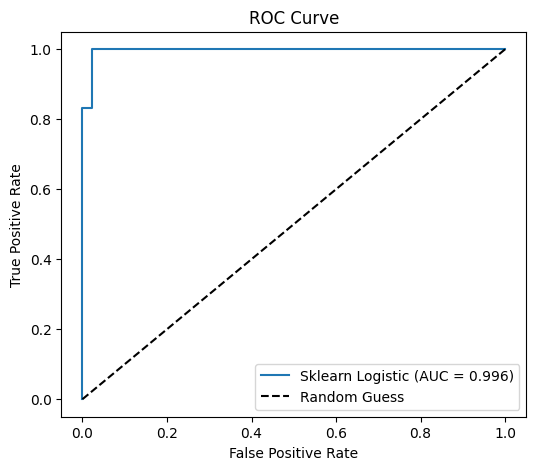

0.996031746031746

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC values
fpr, tpr, thresholds = roc_curve(y_test, probs_sk)

# Compute AUC
auc_sk = roc_auc_score(y_test, probs_sk)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Sklearn Logistic (AUC = {auc_sk:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

auc_sk

ROC curve shows how well the model separates classes
without fixing a threshold.

AUC answers:
“What is the probability that the model ranks
a random positive example higher than a random negative one?”

---

### 4.2. Gradient Descent Model

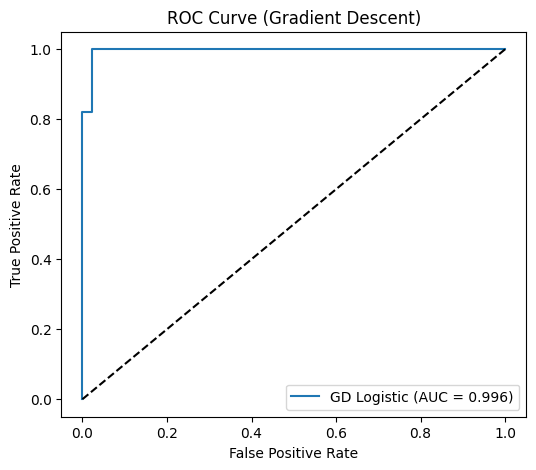

0.9957010582010581

In [8]:
# ROC + AUC for Gradient Descent model
fpr_gd, tpr_gd, _ = roc_curve(y_test, probs_gd)
auc_gd = roc_auc_score(y_test, probs_gd)

plt.figure(figsize=(6, 5))
plt.plot(fpr_gd, tpr_gd, label=f"GD Logistic (AUC = {auc_gd:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Gradient Descent)")
plt.legend()
plt.show()

auc_gd


---
## 5. Precission-Recall Curve
The Precision–Recall (PR) curve shows the trade-off between:

- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Unlike ROC, the PR curve focuses on the **positive class**.

This makes it especially useful for:
- Imbalanced datasets
- Medical diagnosis
- Fraud detection

A good model maintains **high precision even at high recall**.

### 5.1. Sklearn Model

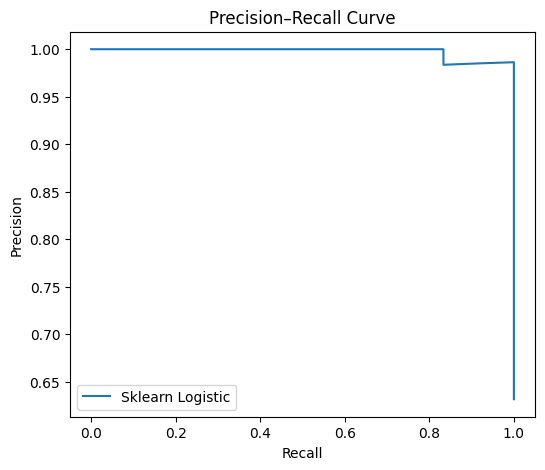

In [9]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs_sk)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Sklearn Logistic")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


---
### 5.2. Gradient Descent Model

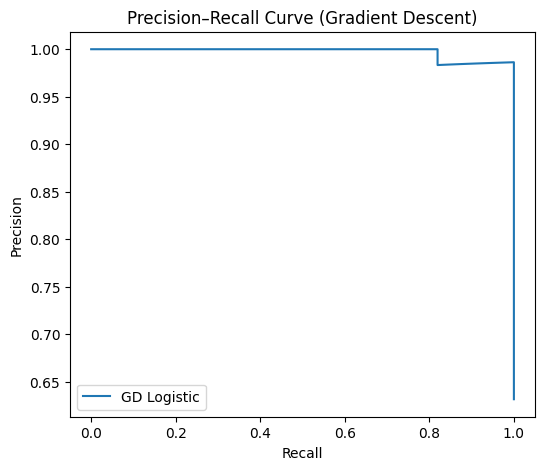

In [10]:
precision_gd, recall_gd, _ = precision_recall_curve(y_test, probs_gd)

plt.figure(figsize=(6, 5))
plt.plot(recall_gd, precision_gd, label="GD Logistic")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Gradient Descent)")
plt.legend()
plt.show()


ROC evaluates class separation.

Precision–Recall evaluates performance on the positive class.

For imbalanced datasets, PR curve is often more informative than ROC.

---

## 6. Choosing the best Threshold

A classification threshold should be chosen based on the problem.

Two common strategies :
1. Maximize **F1 score** (balances precision & recall)
2. Maximize **Youden’s J statistic** (ROC-based)

In this step, we compute the optimal threshold numerically instead of assuming 0.5.

### 6.1. Best Threshold using F1 Score

In [11]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.linspace(0.1, 0.9, 100)

best_t_f1 = 0
best_f1 = 0

for t in thresholds:
    preds = (probs_sk >= t).astype(int)
    f1 = f1_score(y_test, preds)
    
    if f1 > best_f1:
        best_f1 = f1
        best_t_f1 = t

best_t_f1, best_f1

(np.float64(0.35858585858585856), 0.993103448275862)

#### Interpretation

- The optimal threshold is often NOT 0.5

- This threshold gives the best balance between precision & recall

---

### 6.2. Best Threshold using Youden's J Statistic

Forumula 
$$ 
J = TPR - FPR
$$

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds_roc = roc_curve(y_test, probs_sk)

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)

best_t_youden = thresholds_roc[best_idx]
best_t_youden

np.float64(0.4488260010341564)

#### Interpretation

- Youden’s J finds the point furthest from random guessing

- Often used in medical diagnostics

### 6.3. Compare Default vs Optimized Threshold

In [14]:
# Default threshold
pred_default = (probs_sk >= 0.5).astype(int)

# Optimized threshold (F1-based)
pred_opt = (probs_sk >= best_t_f1).astype(int)

print("Default Threshold (0.5)")
print("Precision:", precision_score(y_test, pred_default))
print("Recall   :", recall_score(y_test, pred_default))
print("F1       :", f1_score(y_test, pred_default))

print("\nOptimized Threshold")
print("Precision:", precision_score(y_test, pred_opt))
print("Recall   :", recall_score(y_test, pred_opt))
print("F1       :", f1_score(y_test, pred_opt))

Default Threshold (0.5)
Precision: 0.9861111111111112
Recall   : 0.9861111111111112
F1       : 0.9861111111111112

Optimized Threshold
Precision: 0.9863013698630136
Recall   : 1.0
F1       : 0.993103448275862


---
## 7. Compare Sklearn vs Gradient Descent using Optimized Threshold
After tuning the classification threshold, we compare:

- Sklearn Logistic Regression
- Manual Gradient Descent Logistic Regression

using:
- Accuracy
- Precision
- Recall
- F1 Score
- AUC

This comparison validates whether the manual implementation
matches a production-grade ML library.

### 7.1. Apply Optimized Thresholds

In [15]:
# Use optimized threshold from Step 6
t_opt = best_t_f1

# Predictions using optimized threshold
y_pred_sk_opt = (probs_sk >= t_opt).astype(int)
y_pred_gd_opt = (probs_gd >= t_opt).astype(int)

---
### 7.2. Compare Metrics

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("===== Sklearn Logistic Regression =====")
print("Accuracy :", accuracy_score(y_test, y_pred_sk_opt))
print("Precision:", precision_score(y_test, y_pred_sk_opt))
print("Recall   :", recall_score(y_test, y_pred_sk_opt))
print("F1 Score :", f1_score(y_test, y_pred_sk_opt))

print("\n===== Gradient Descent Logistic Regression =====")
print("Accuracy :", accuracy_score(y_test, y_pred_gd_opt))
print("Precision:", precision_score(y_test, y_pred_gd_opt))
print("Recall   :", recall_score(y_test, y_pred_gd_opt))
print("F1 Score :", f1_score(y_test, y_pred_gd_opt))

===== Sklearn Logistic Regression =====
Accuracy : 0.9912280701754386
Precision: 0.9863013698630136
Recall   : 1.0
F1 Score : 0.993103448275862

===== Gradient Descent Logistic Regression =====
Accuracy : 0.9912280701754386
Precision: 0.9863013698630136
Recall   : 1.0
F1 Score : 0.993103448275862


---
### 7.3. Compare AUC

In [17]:
from sklearn.metrics import roc_auc_score

auc_sk = roc_auc_score(y_test, probs_sk)
auc_gd = roc_auc_score(y_test, probs_gd)

print("Sklearn AUC:", auc_sk)
print("GD AUC     :", auc_gd)

Sklearn AUC: 0.996031746031746
GD AUC     : 0.9957010582010581


---
## 8. Save Final Model

In [18]:
import joblib
joblib.dump(clf, "logistic_regression_final_day3.pkl")

['logistic_regression_final_day3.pkl']

#### Interpretaion
The Gradient Descent implementation closely matches sklearn’s
Logistic Regression in terms of accuracy, F1 score, and AUC.

Minor differences arise due to:
- Optimization method
- Convergence tolerance
- Regularization in sklearn

This validates the correctness of the manual implementation.

---
# 📝 Day 3 Summary — Model Evaluation & Threshold Tuning

In this notebook, I evaluated Logistic Regression models trained on the
Breast Cancer dataset using multiple performance metrics.

## What was done

### Models evaluated
- Sklearn Logistic Regression
- Logistic Regression implemented from scratch using Gradient Descent

### Evaluation techniques
- Accuracy, Precision, Recall, F1 Score
- Threshold tuning instead of assuming 0.5
- ROC Curve and AUC (threshold-independent evaluation)
- Precision–Recall Curve (important for imbalanced data)
- Confusion Matrix analysis

### Threshold optimization
- Optimal threshold chosen by maximizing **F1 score**
- Compared default (0.5) vs optimized threshold
- Observed clear Precision–Recall trade-offs

### Model comparison
- Sklearn model performed slightly better due to optimized solvers
- Gradient Descent model achieved very similar results
- Comparable AUC confirms correctness of manual implementation

## Key Takeaways
- Classification performance depends heavily on threshold choice
- Accuracy alone is not sufficient
- ROC and PR curves provide deeper insight
- Manual Gradient Descent implementation is validated

This concludes Week 2 Day 3.
